In [10]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [11]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/sin_maxwell_protocols_data.xlsx'

df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    #去除 sheet_data 中的零值
    sheet_data = sheet_data[(sheet_data != 0).all(axis=1)]
    if i==3:
        data_valid=sheet_data
    else :
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)

x1_d_HF = torch.tensor(data_train['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_train['Time'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_train['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_train['Stress'].values, dtype=torch.float32).view(-1, 1)
# 计算边界

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)

lb = torch.tensor([x1min, x2min,x3min ,y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max,x3max,y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    if lb==ub:
        return vectors
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
x3_d_HF = norm(x3_d_HF, lb[2], ub[2])
y1_d_HF = norm(y1_d_HF, lb[3], ub[3])
# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF,x3_d_HF], dim=1)

y_data_HF= torch.cat([y1_d_HF], dim=1) # 默认训练储存模量

Xy_data_HF = torch.cat([X_data_HF,y_data_HF], dim=1)

# 定义模型
in_dim, out_dim = 3, 1

In [12]:
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加第一层全连接层（从 GRU 的隐藏状态映射到中间层）
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 中间层的维度可以与 hidden_size 相同
        
        # 添加第二层全连接层（从中间层映射到输出维度）
        self.out = nn.Linear(hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
      
        return X


torch.Size([7986, 10, 3])
torch.Size([7986, 1])


ValueError: x and y can be no greater than 2D, but have shapes (1990, 1) and (1990, 10, 3)

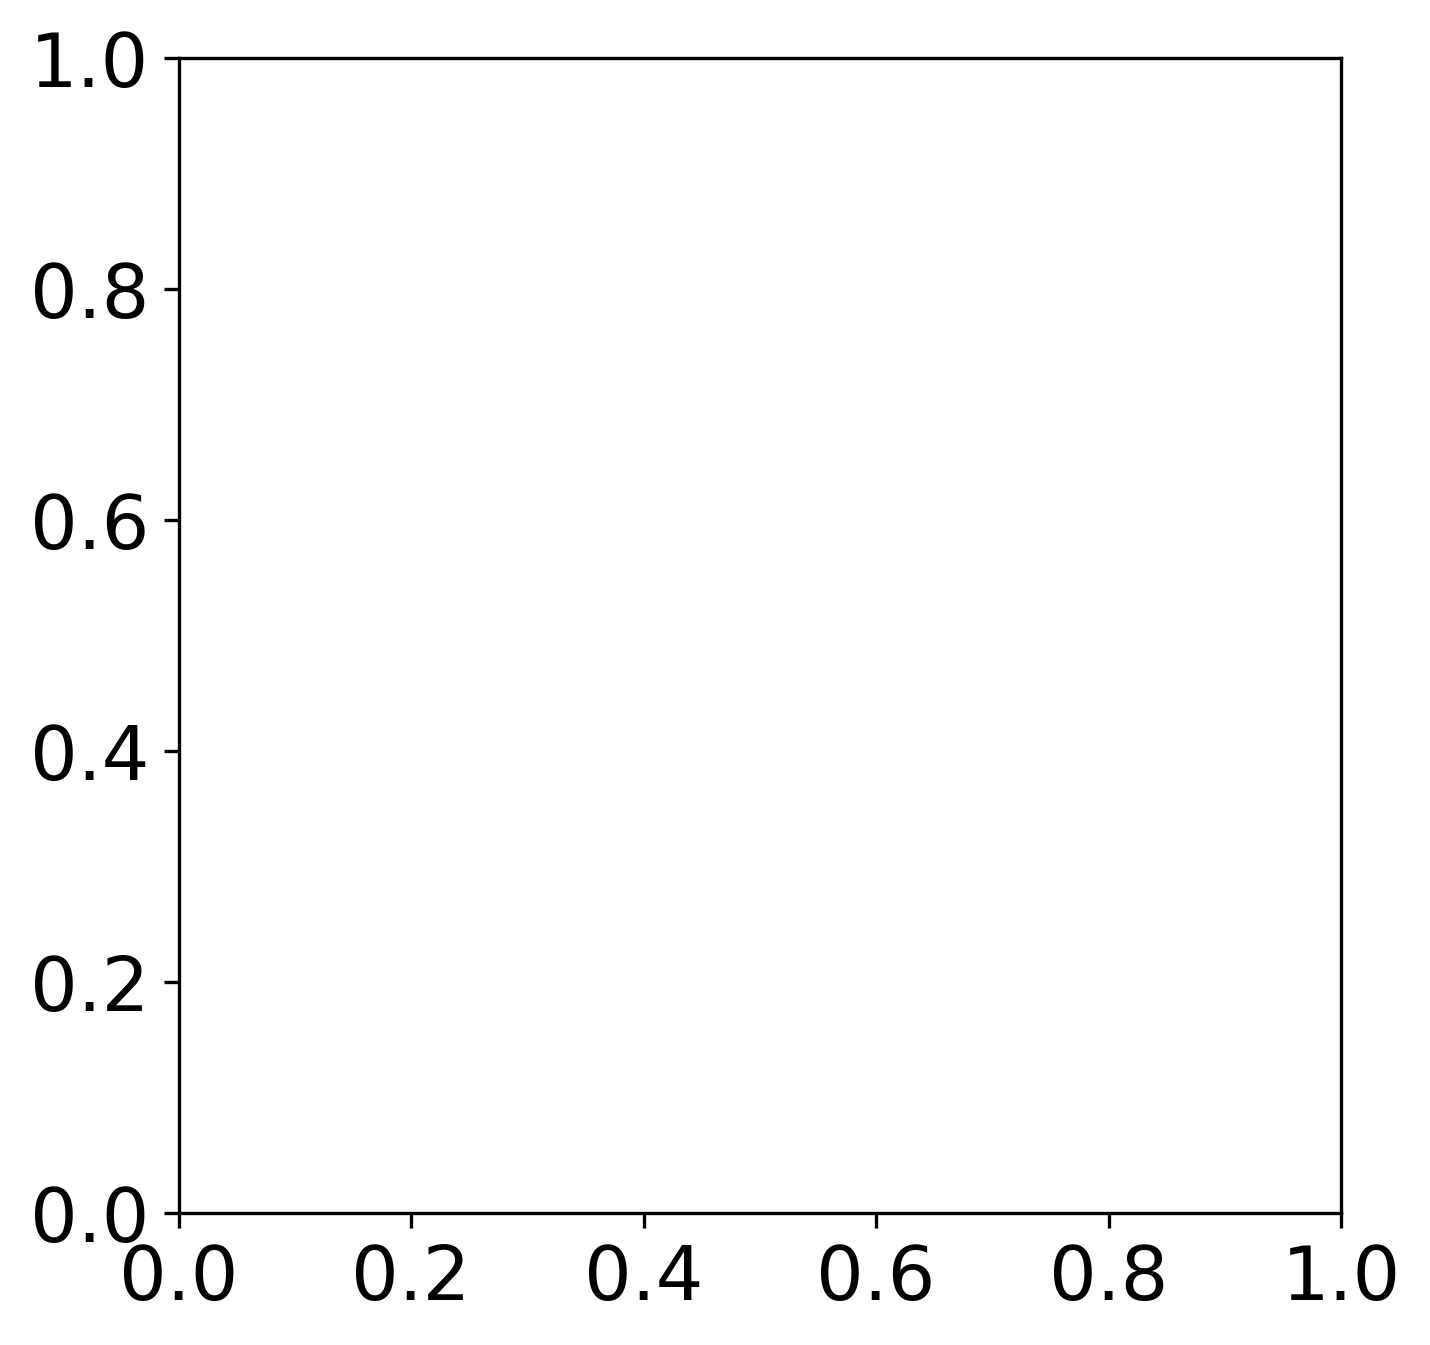

In [14]:
model=torch.load('model/maxwell_lstm_sin_de_l.pth')
model.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
R2 = 0
MAE = 0
MSE = 0
MAPE=0
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points//100)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
   # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
    x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    x3_test = norm(x3_test, lb[2], ub[2])
    y1_test = norm(y1_test, lb[3], ub[3]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1)
    X_MF=create_dynamic_window(X_MF,time_steps)
    y_MF = model(X_MF) 
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().numpy(), lb[3], ub[3])

     # 绘制数据
   
    if value == 4:
        ax.plot((denorm(x1_test[time_steps-1:],lb[0],ub[0])), y_MF_denorm, color=colors[3],label=f'Predict')
        ax.scatter(sampled_test_data["Strain"].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors[5], marker='o', facecolors='none', 
                   label=f'(Test)',s=12)
        R2 = r2_score(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        MAE = mean_absolute_error(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        MSE = mean_squared_error(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        # 计算 MAPE
        def calculate_mape(y_true, y_pred):
        # 计算每个样本的绝对百分比误差
         absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
        # 计算平均值并乘以 100 得到百分比
         mape = np.mean(absolute_percentage_error) 
         return mape

        MAPE = calculate_mape(test_data['Stress'].values[time_steps-1:], y_MF_denorm)
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Strain$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.26, 0.83))
ax.text(0.7, 0.6, f'LSTM:\nR²: {R2:.4f}\nMAE: {MAE:.4f}\nMAPE: {MAPE:.4f}', 
        transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=None,color='tab:blue')

#ax.invert_xaxis()
plt.show()